In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from textblob_nl import PatternTagger, PatternAnalyzer
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [168]:
df = pd.read_csv('Data cleanedv2.csv', header = 0, sep= ';')

# Exploratory Data Analasys

## 1. Dataset preparation

### Extracting Travel Month feature from Arrival

In [169]:
# Transforming the Arrival date feature into Travel Month

df['Aankomst'] = pd.to_datetime(df['Aankomst'], format='%d/%m/%Y')

# Extracting the month and creating the 'Travel Month' column
df['Travel Month'] = df['Aankomst'].dt.month

### Dropping Features that are not used, Duplicates and Missing Values

In [171]:
df.drop(columns=['Received Messages', 'Aankomst', 'Vertrek', 'Boekingsnummer'], inplace=True)

In [173]:
def drop_na(dataset, column):
    """
    Drops rows with missing values in the specified column from the dataset

    Parameters:
    dataset: The dataset containing the data (df)
    column: The name of the column where missing values should be checked and removed (str)
    """
    dataset.dropna(subset=[column], inplace=True)

drop_na(df, 'Grade')
drop_na(df, 'Gespreksdata')

In [174]:
# Dropping duplicates in the dataset

df.drop_duplicates(inplace=True)

In [176]:
df.shape

(12822, 5)

### Cleaning Text Feature

In [177]:
stopwords = set(STOPWORDS)
stopwords.update(["en", "is", "zijn", "was", "oke", "ok", "of", "dat", "voor",
                 "ons", "naar", "maar", "dus", "die", "bij", "een", "hebben", "dan", "mee", "daar",
                 "is", "heb", "zou", "kan", "aan", "iets", "hier",
                 "met", "moet", "gaan", 'deze', 'graag', 'alle', 'zeker', 'maken', 'nog', 'hoor', 'al', 'zouden', 'vanaf',
                 'toch', 'jij', 'zitten', 'waar', 'meer', 'gedaan', 'ben', 'geven', 'even', 'als', 'alles', 'doen', 'via', 
                 'kunnen', 'jullie', 'onze', 'door', 'mag', 'willen', 'staan', 'weet', 'krijgt', 'houden', 'gaat',
                 'geef', 'zien', 'daarna', 'wij', 'weten', 'komen', 'omdat', 'mijn', 'op', 'de', 'aan'])

In [178]:
def clean_text(text):
    """
    Cleans the chat message feature by removing non-alphabetic characters, 
    single characters and stopwords.

    Parameters:
    text: The input feature consisting of text to be cleaned (str)

    Returns:
    Cleaned text (str)
    """
    
    text = ''.join([char if char.isalpha() else ' ' for char in text.lower()])
    text = ' '.join(word for word in text.split() if len(word) > 1)
    text = ' '.join(word for word in text.split() if word not in stopwords)

    return text

df['Gespreksdata'] = df['Gespreksdata'].apply(clean_text)

### Extracting Sentiment Score from Chat Message feature

In [179]:
def compute_sentiment_score(text):
    blob = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    return blob.sentiment[0]

def compute_subjectivity_score(text):
    blob = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    return blob.sentiment[1]

df['sentiment_score'] = df['Gespreksdata'].apply(compute_sentiment_score)
df['subjectivity_score'] = df['Gespreksdata'].apply(compute_subjectivity_score)

### Rounding Grades

In [180]:
# Rounding grades to the nearest half integers to make the variable more interpretable and to group unique grades

df['Rounded_Grade'] = df['Grade'].apply(lambda x: 1.0 if x == 0.0 else round(x * 2) / 2)
grade_counts = df['Rounded_Grade'].value_counts()

df_filtered = df[df['Rounded_Grade'].isin(grade_counts[grade_counts > 1].index)]
df_filtered.drop(columns=['Grade'], inplace=True)

df_filtered.rename(columns={'Rounded_Grade': 'Grade'}, inplace=True)
df = df_filtered

In [181]:
df.head()

,Land,Travel Duration,Gespreksdata,Travel Month,sentiment_score,subjectivity_score,Grade
0,528,4,sophie sophie sophie je weer je hetzelfde bedankt,3,0.000000,0.300000,10.0
3,528,4,sophie sophie ja je volgende keer weer wíj je ...,3,0.000000,0.200000,9.0
6,528,2,sophie sophie van wandelen nijmegen ook zoek r...,2,0.179167,0.714583,8.0
10,528,2,sophie sophie dagen overijssel landgoed holtwe...,2,0.465000,0.600000,8.0
11,528,3,sophie vraagje golf spelen golfbaan kelpenberg...,3,0.266667,0.483333,10.0


In [183]:
df['Land'] = df['Land'].astype(int)

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12822 entries, 0 to 22881
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Land                12822 non-null  int64  
 1   Travel Duration     12822 non-null  int64  
 2   Gespreksdata        12822 non-null  object 
 3   Travel Month        12822 non-null  int32  
 4   sentiment_score     12822 non-null  float64
 5   subjectivity_score  12822 non-null  float64
 6   Grade               12822 non-null  float64
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 751.3+ KB


In [185]:
df.describe()

,Land,Travel Duration,Travel Month,sentiment_score,subjectivity_score,Grade
count,12822.000000,12822.000000,12822.000000,12822.000000,12822.000000,12822.000000
mean,443.030027,9.474575,7.084542,0.246139,0.552064,7.778116
std,219.580828,9.584005,2.684548,0.241473,0.317406,1.730265
min,8.000000,1.000000,1.000000,-1.000000,-0.050000,1.000000
25%,250.000000,4.000000,6.000000,0.000000,0.400000,7.000000
50%,405.000000,7.000000,7.000000,0.250000,0.643810,8.000000
75%,620.000000,14.000000,9.000000,0.404167,0.772222,9.000000
max,840.000000,334.000000,12.000000,1.000000,1.000000,10.000000


## 2. Target Feature Analysis

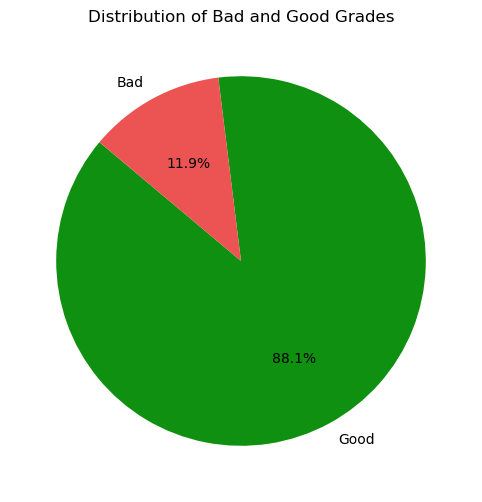

In [187]:
threshold = 6

# Categorize grades
df['Grade_Category'] = df['Grade'].apply(lambda x: 'Bad' if x <= threshold else 'Good')

# Count the number of grades in each category
grade_counts = df['Grade_Category'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(grade_counts, labels=grade_counts.index, colors=['#109010', '#ec5353'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Bad and Good Grades')
plt.savefig('pie chart grades')
plt.show()

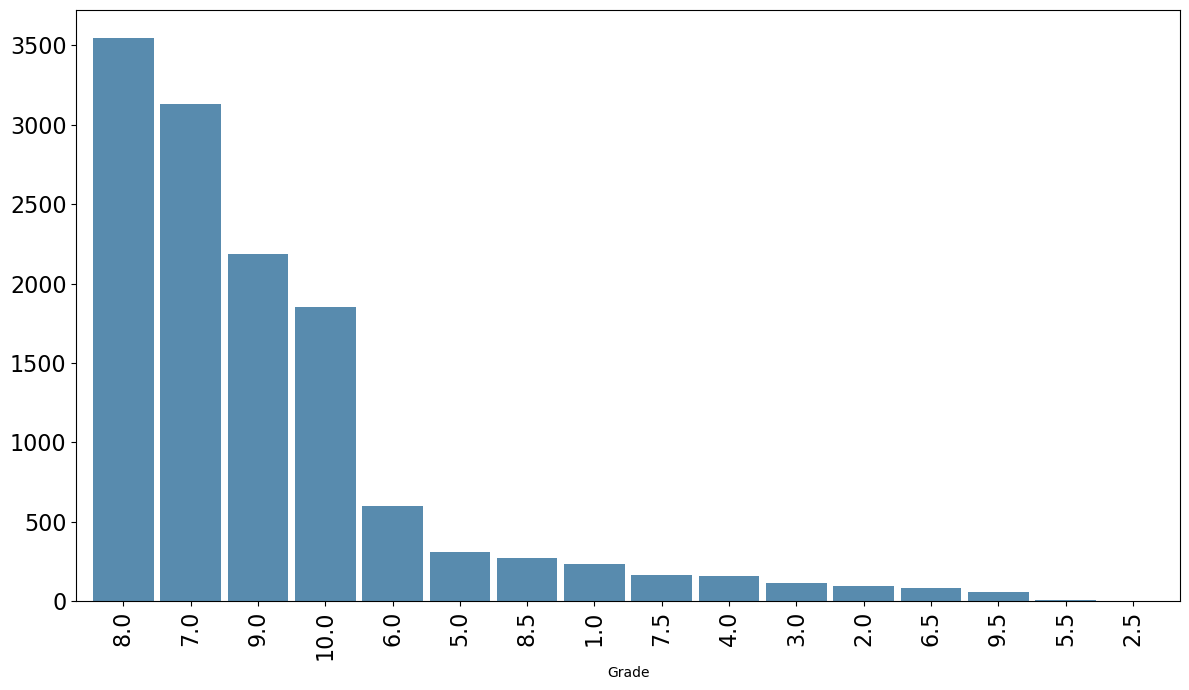

In [84]:
# Distribution of target feature "Grade"

plt.figure(figsize=(12, 7))
df["Grade"].value_counts().plot(kind="bar", color='#588BAE', width=0.9, fontsize=16)
plt.xlabel('Grade')
plt.tight_layout()
plt.show()

## 3. Input Feature Analysis

### Chat Data Feature

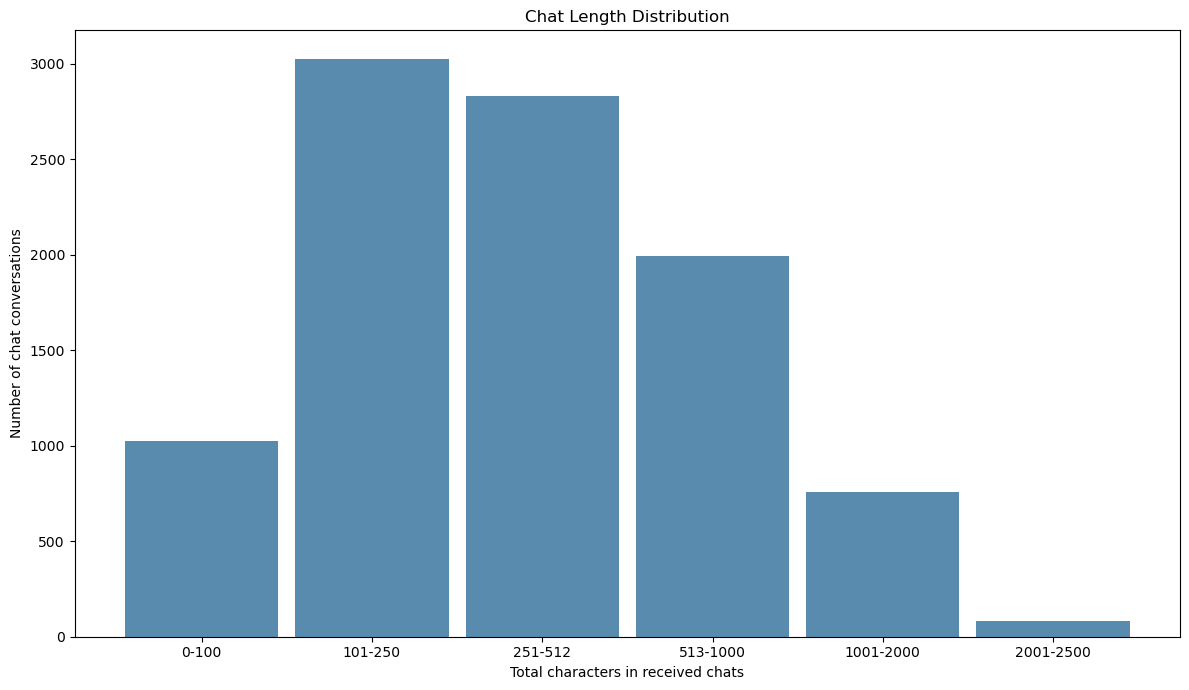

In [90]:
df2 = df
df2['Gespreksdatalength'] = df2['Gespreksdata'].apply(lambda x: len(str(x)))
df2 = df2[['Gespreksdata', 'Gespreksdatalength']]
df2 = df2[df2['Gespreksdata'].apply(lambda x: len(str(x)) >= 2)]
df2['Gespreksdatalength'] = pd.to_numeric(df2['Gespreksdatalength'])


a = df2[df2['Gespreksdatalength'] <= 20].count()[0]

counts = []
categories = ['0-100', '101-250', '251-512', '513-1000', '1001-2000', '2001-2500',]

counts.append(a)
for i in range(1, len(categories)):
    count = df2[(df2['Gespreksdatalength'] <= int(categories[i].split('-')[-1])) &
               (df2['Gespreksdatalength'] > int(categories[i-1].split('-')[-1]))].count()[0]
    counts.append(count)

plt.figure(figsize=(12, 7))
plt.bar(categories, counts, color='#588BAE', width=0.9)
plt.title('Chat Length Distribution')
plt.xlabel('Total characters in received chats')
plt.ylabel('Number of chat conversations')
plt.tight_layout()
plt.show()

### Travel Month Feature

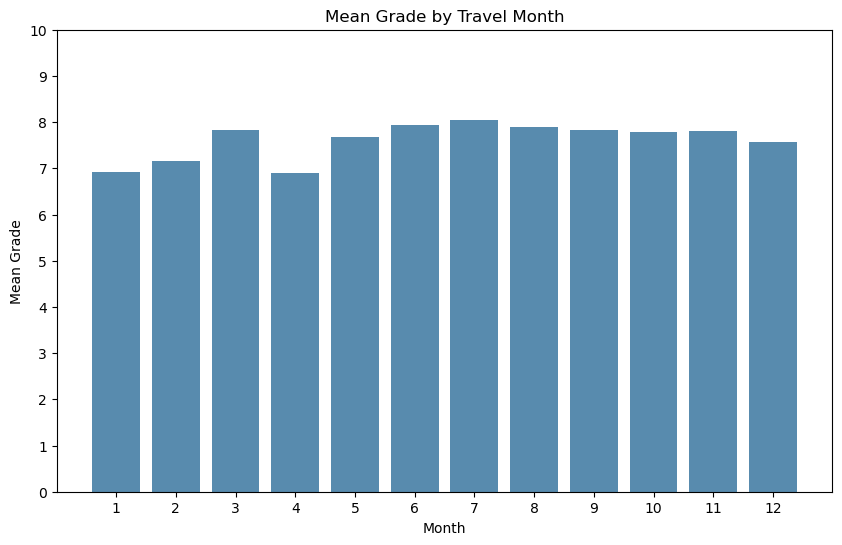

In [91]:
mean_grade_by_month = df.groupby('Travel Month')['Grade'].mean()

# Plot histogram of mean grades for each month
plt.figure(figsize=(10, 6))
plt.bar(mean_grade_by_month.index, mean_grade_by_month.values, color='#588BAE')
plt.xlabel('Month')
plt.ylabel('Mean Grade')
plt.title('Mean Grade by Travel Month')
plt.xticks(range(1, 13))
plt.ylim(0, 10)

plt.yticks(range(11))
plt.show()

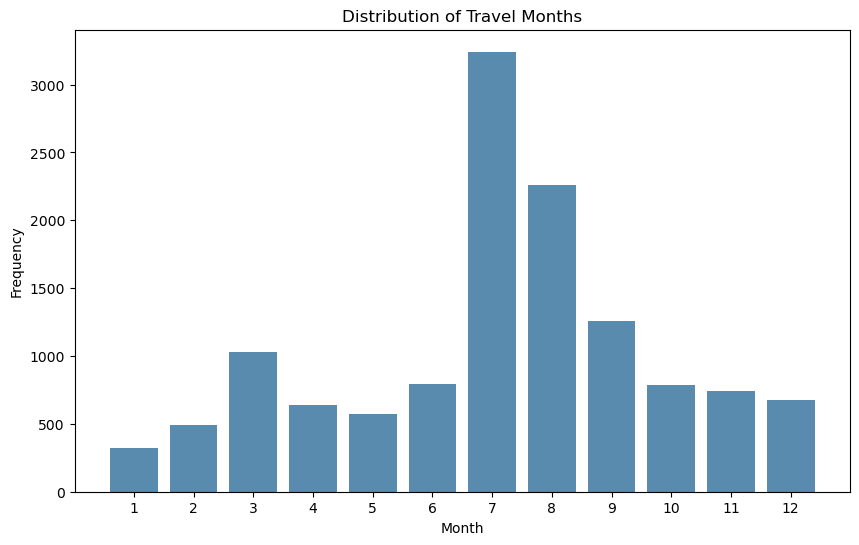

In [100]:
# Plotting the frequency of each Travel Month

month_counts = df['Travel Month'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(month_counts.index, month_counts.values, color='#588BAE')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Distribution of Travel Months')
plt.xticks(range(1, 13))
plt.show()

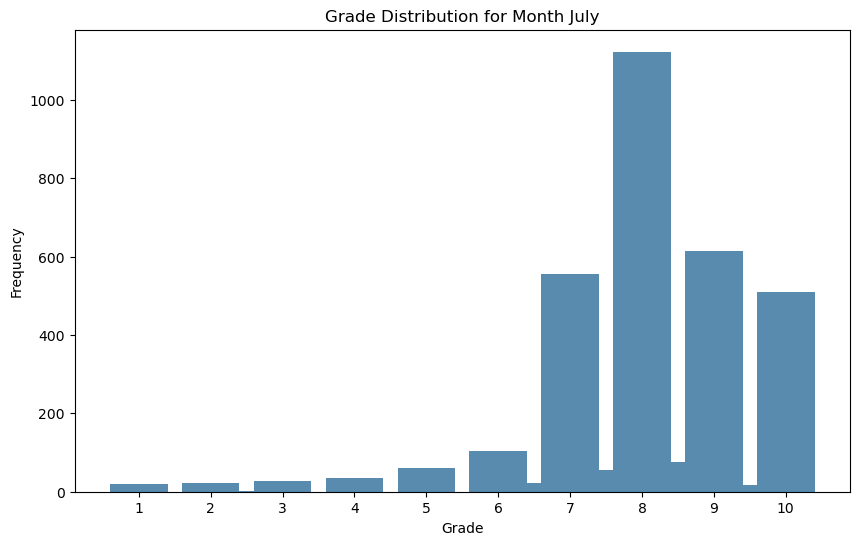

In [103]:
# Plotting the Grade distribution for the most common month: July (7)

month_7_data = df[df['Travel Month'] == 7]
grade_counts_month_7 = month_7_data['Grade'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(grade_counts_month_7.index, grade_counts_month_7.values, color='#588BAE')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.title('Grade Distribution for Month July')
plt.xticks(range(1, 11))
plt.show()

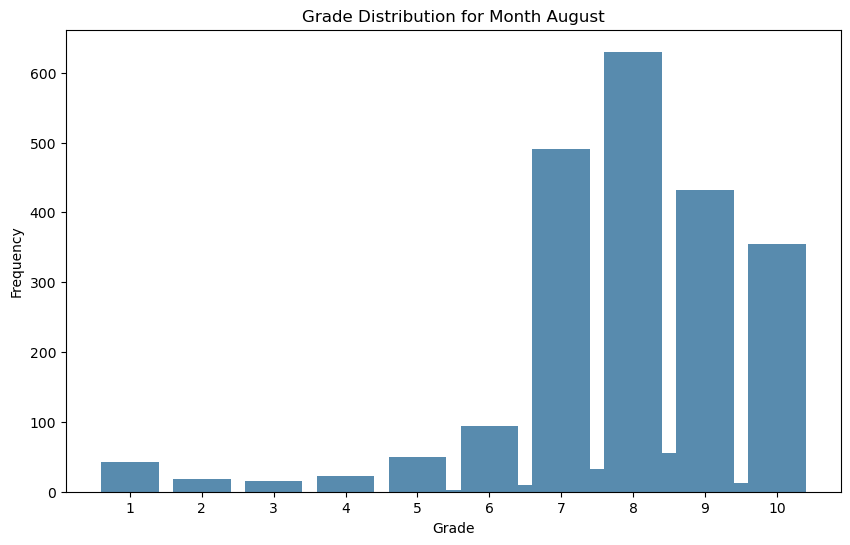

In [102]:
# Plotting the Grade distribution for the second most common month: August (8)

month_8_data = df[df['Travel Month'] == 8]
grade_counts_month_8 = month_8_data['Grade'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(grade_counts_month_8.index, grade_counts_month_8.values, color='#588BAE')  # Assuming grade colors as orange
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.title('Grade Distribution for Month August')
plt.xticks(range(1, 11)) 
plt.show()

### Travel Duration Feature

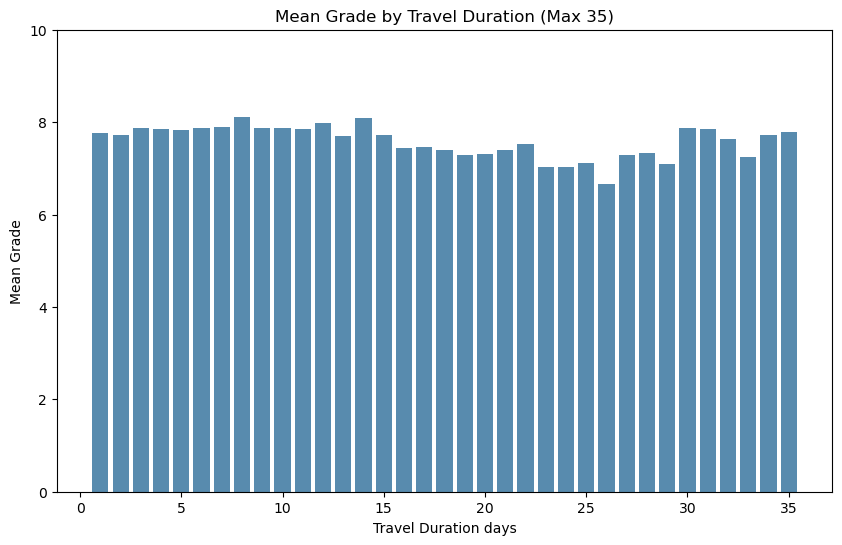

In [106]:
# Plotting the average Grade for Travel Duration with a maximum of 35 days

filtered_df = df[df['Travel Duration'] <= 35]

mean_grade_by_duration = filtered_df.groupby('Travel Duration')['Grade'].mean().sort_index()

# Plot mean grade for each travel duration
plt.figure(figsize=(10, 6))
plt.bar(mean_grade_by_duration.index, mean_grade_by_duration.values, color='#588BAE')
plt.xlabel('Travel Duration days')
plt.ylabel('Mean Grade')
plt.title('Mean Grade by Travel Duration (Max 35)')
plt.ylim(0, 10)
plt.show()

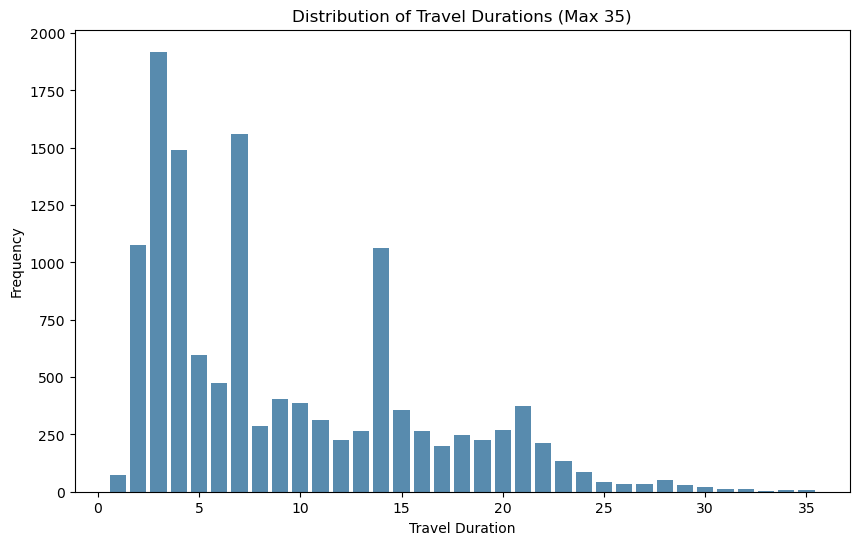

In [108]:
# Plotting the frequency of Travel Duration with a maximum of 35 days

filtered_df = df[df['Travel Duration'] <= 35]
duration_counts = filtered_df['Travel Duration'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(duration_counts.index, duration_counts.values, color='#588BAE')
plt.xlabel('Travel Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Travel Durations (Max 35)')
plt.show()

### Travel Destination Feature

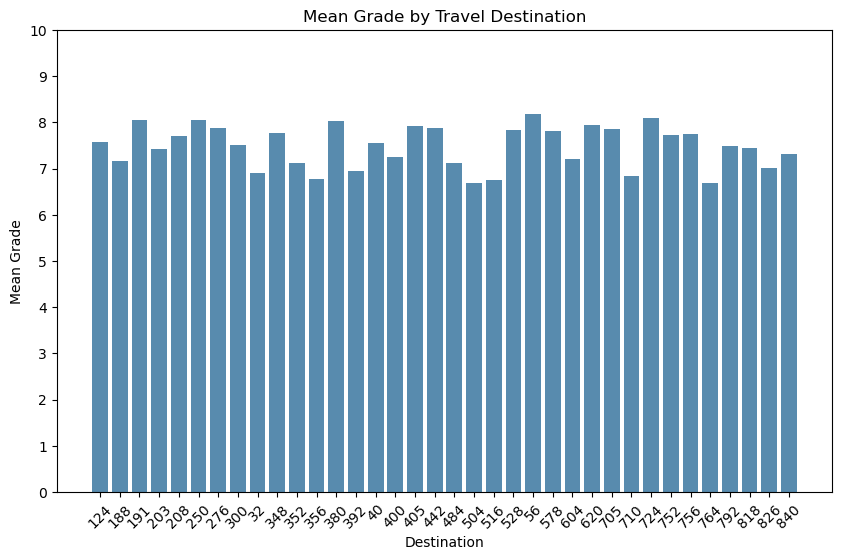

In [96]:
# Plotting the average Grade for each country that occurs at least 30 times in the dataset

land_counts = df['Land'].value_counts()
valid_lands = land_counts[land_counts >= 30].index
filtered_df = df[df['Land'].isin(valid_lands)]
mean_grade_by_land = filtered_df.groupby('Land')['Grade'].mean()

plt.figure(figsize=(10, 6))
plt.bar(range(len(mean_grade_by_land)), mean_grade_by_land.values, color='#588BAE')
plt.xlabel('Destination')
plt.ylabel('Mean Grade')
plt.title('Mean Grade by Travel Destination')
plt.xticks(range(len(mean_grade_by_land)), mean_grade_by_land.index, rotation=45)  
plt.ylim(0, 10)
plt.yticks(range(11))
plt.show()

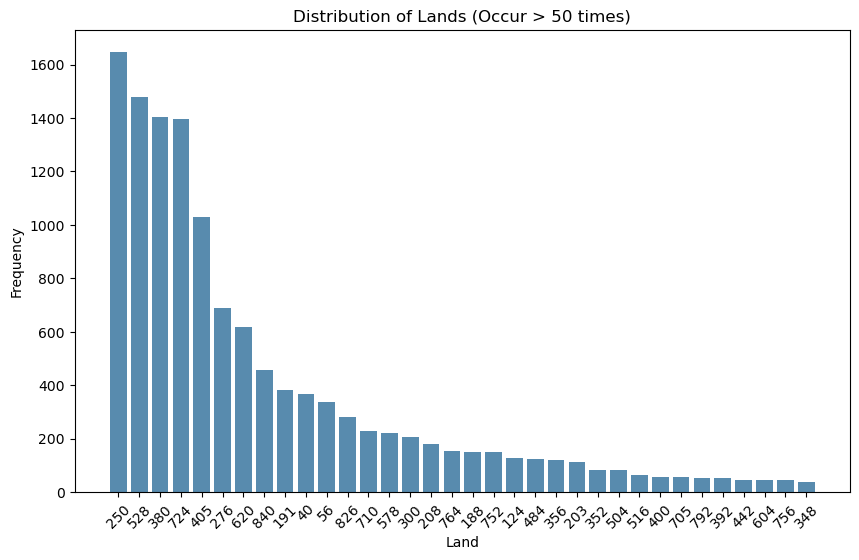

In [110]:
# Plotting the frequency of Travel Destination for lands that occur at least 35 times in the dataset

land_counts = df['Land'].value_counts()
popular_lands = land_counts[land_counts > 35].index.tolist()
popular_land_data = df[df['Land'].isin(popular_lands)]

land_counts_sorted = land_counts_popular.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(land_counts_sorted.index, land_counts_sorted.values, color='#588BAE') 
plt.xlabel('Land')
plt.ylabel('Frequency')
plt.title('Distribution of Lands (Occur > 50 times)')
plt.xticks(rotation=45)
plt.savefig('land_distribution')
plt.show()

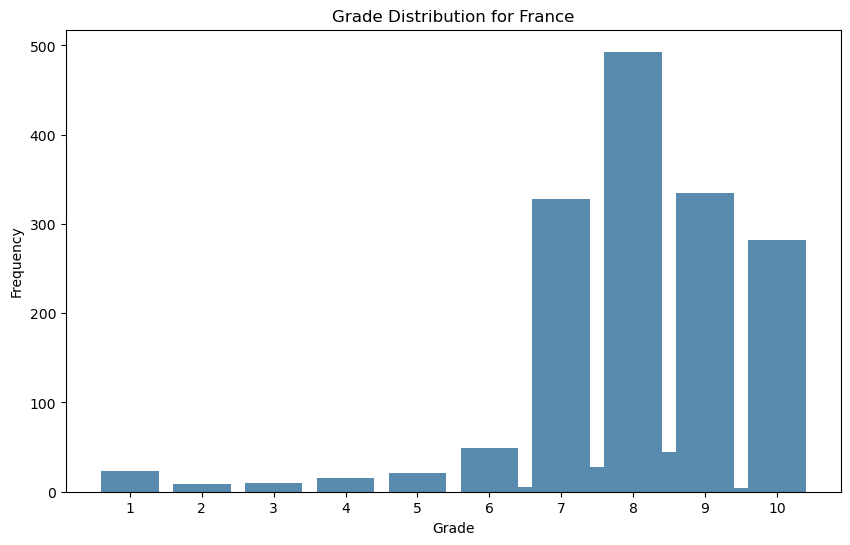

In [111]:
# Plotting the Grade distribution for the most common land in the dataset (250 = France) 

france = df[df['Land'] == "250"]
grade_counts_france = france['Grade'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(grade_counts_france.index, grade_counts_france.values, color='#588BAE')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.title('Grade Distribution for France')
plt.xticks(range(1, 11))  
plt.show()

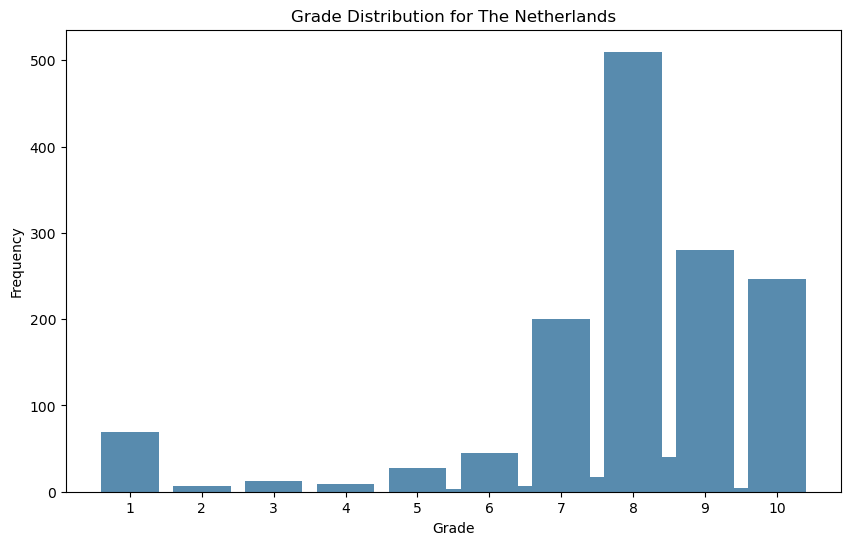

In [112]:
# Plotting the Grade distribution for the second most common country in the dataset (528 = The Netherlands)

NL = df[df['Land'] == "528"]

grade_counts_NL = NL['Grade'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(grade_counts_NL.index, grade_counts_NL.values, color='#588BAE')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.title('Grade Distribution for The Netherlands')
plt.xticks(range(1, 11))  
plt.show()

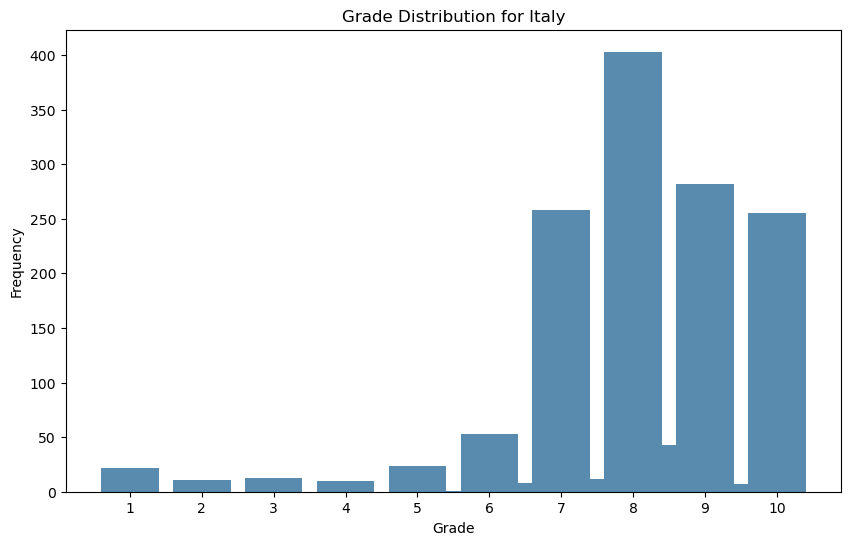

In [115]:
# Plotting the Grade distribution for the third most common country in the dataset (380 = Italy)

italy = df[df['Land'] == "380"]

grade_counts_italy = italy['Grade'].value_counts().sort_index()

# Plot the distribution of grades for month 7
plt.figure(figsize=(10, 6))
plt.bar(grade_counts_italy.index, grade_counts_italy.values, color='#588BAE')  # Assuming grade colors as orange
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.title('Grade Distribution for Italy')
plt.xticks(range(1, 11))  
plt.show()

## 4. Word Cloud Analysis

There are 4279242 words in the combination of all chats.


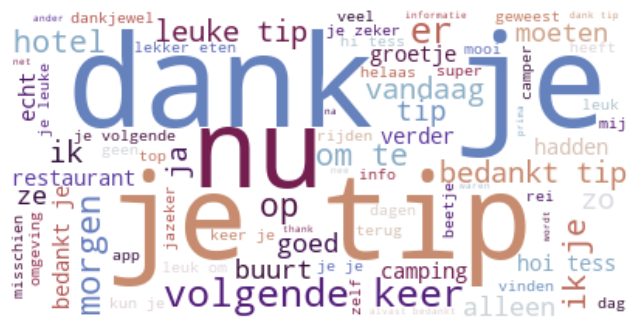

In [252]:
text = " ".join(desc for desc in df["Gespreksdata"].values)
print ("There are {} words in the combination of all chats.".format(len(text)))

wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap="twilight_shifted_r", max_words=75).generate(text)

# Display the generated image
plt.figure(figsize=(8,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show

WORDCLOUD for 10.0


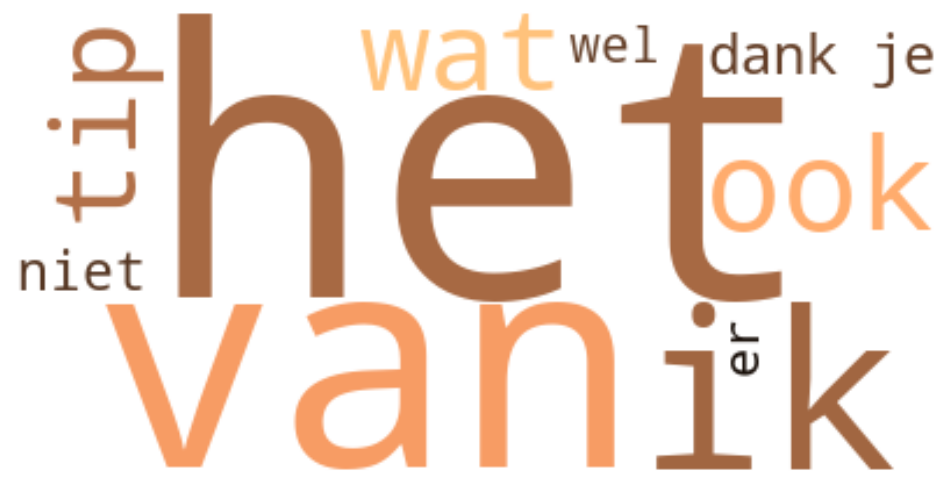

WORDCLOUD for 9.0


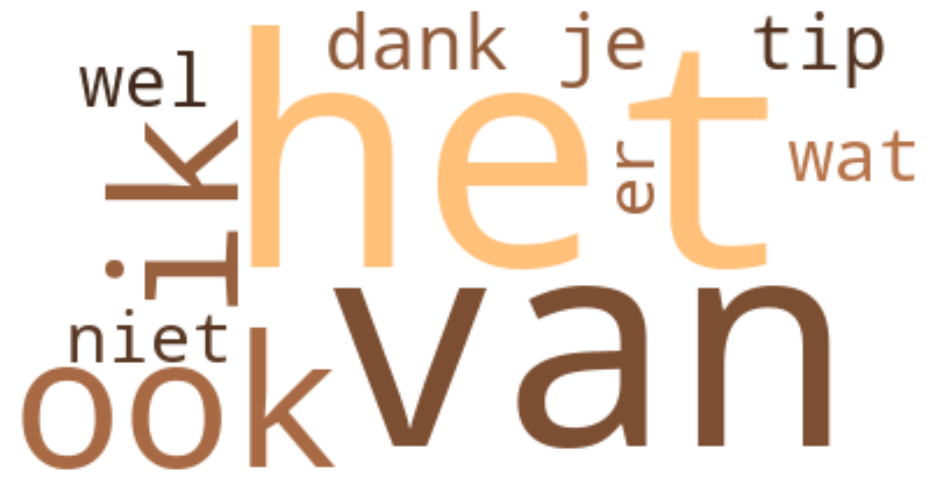

WORDCLOUD for 8.0


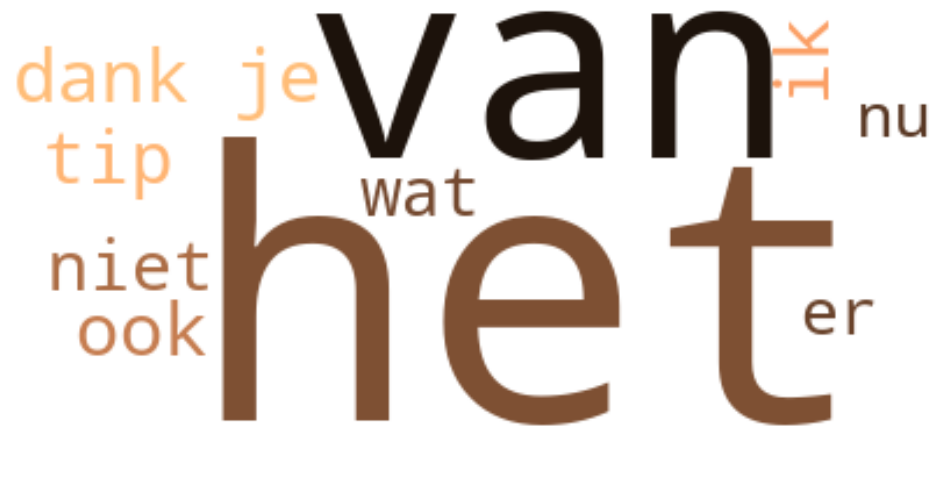

WORDCLOUD for 7.0


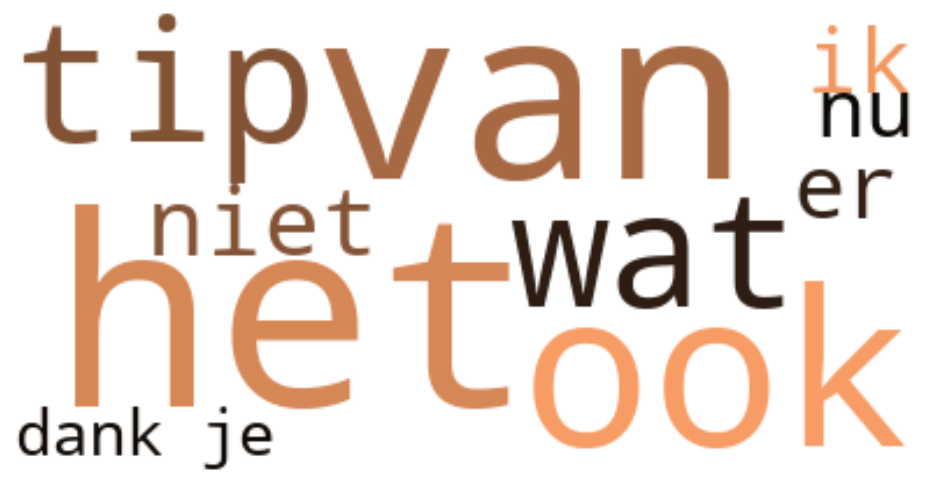

WORDCLOUD for 8.5


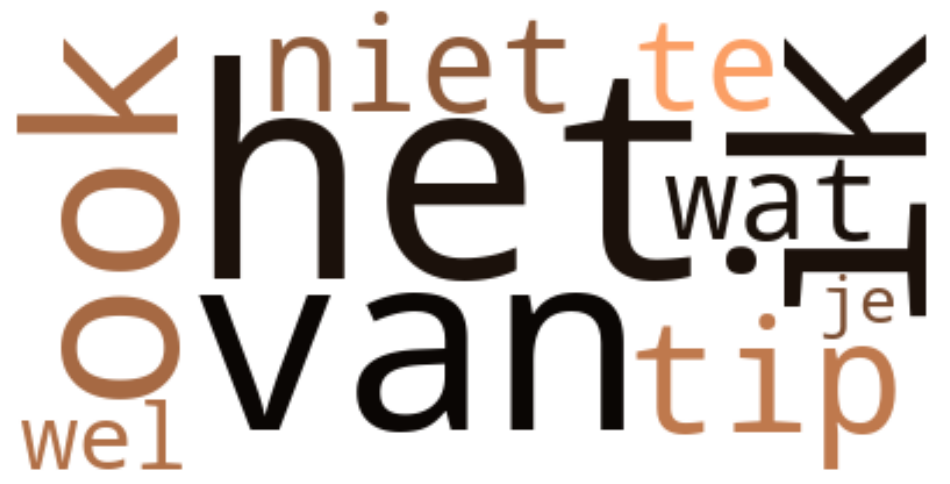

WORDCLOUD for 5.0


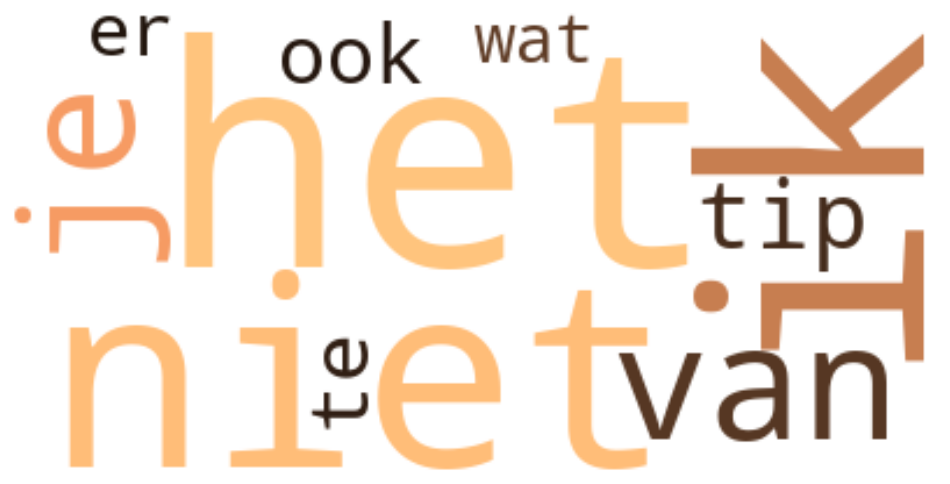

WORDCLOUD for 6.0


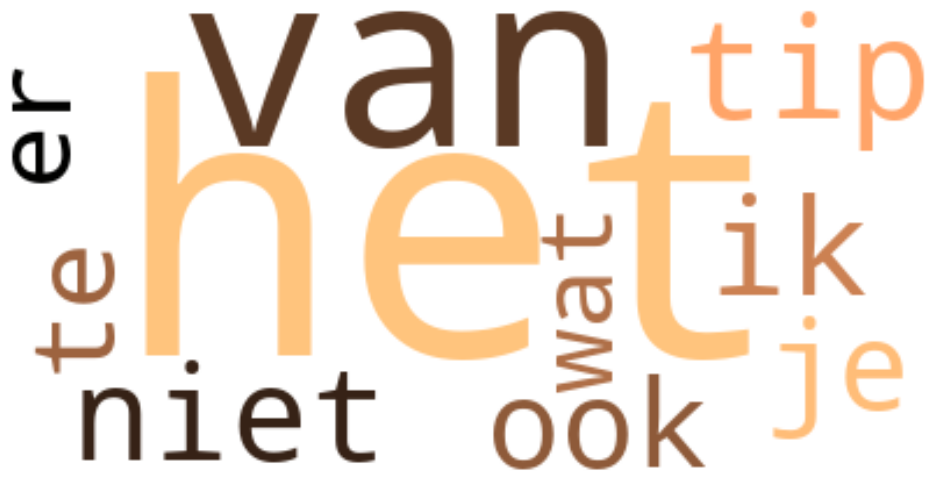

WORDCLOUD for 6.5


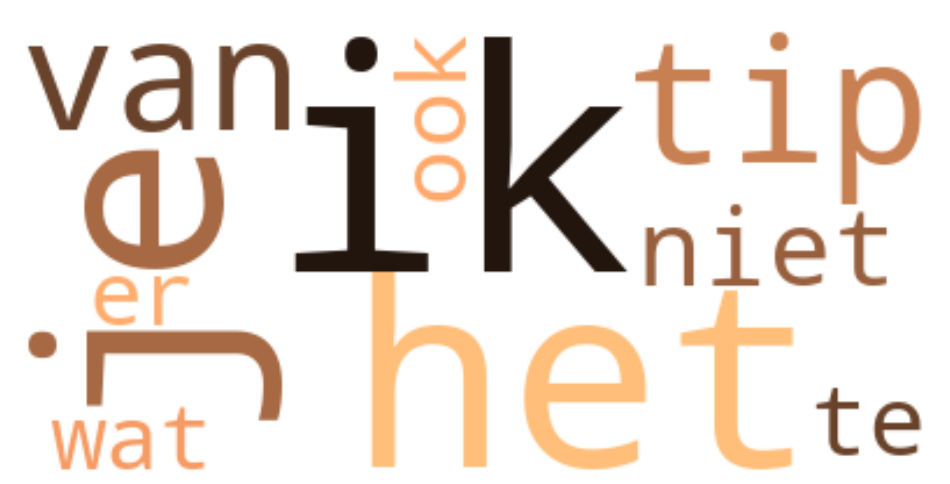

WORDCLOUD for 7.5


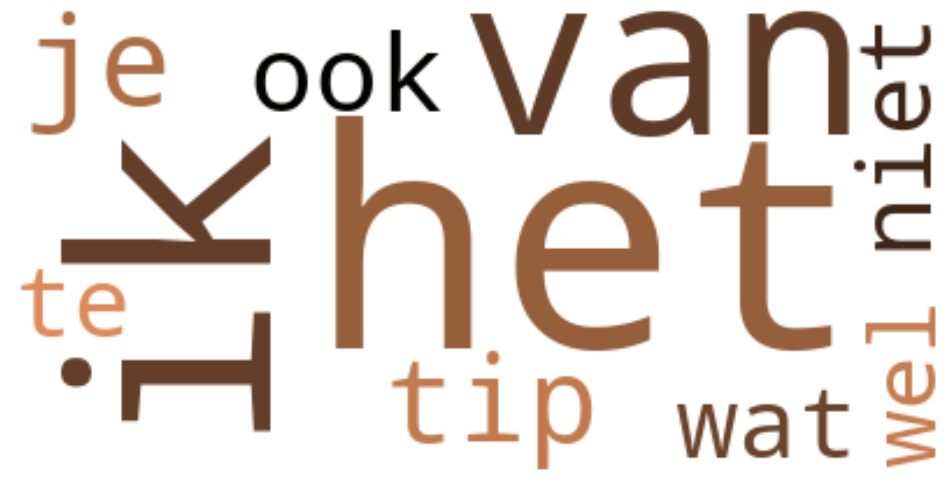

WORDCLOUD for 4.0


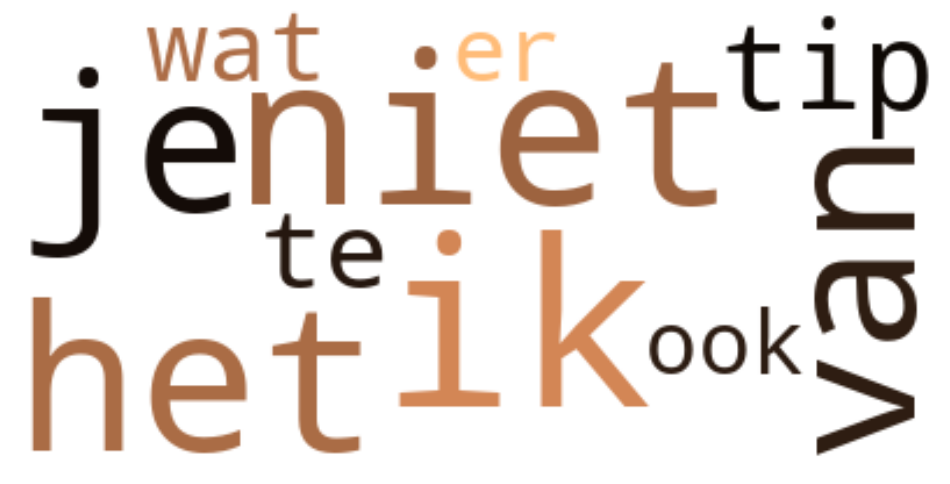

WORDCLOUD for 1.0


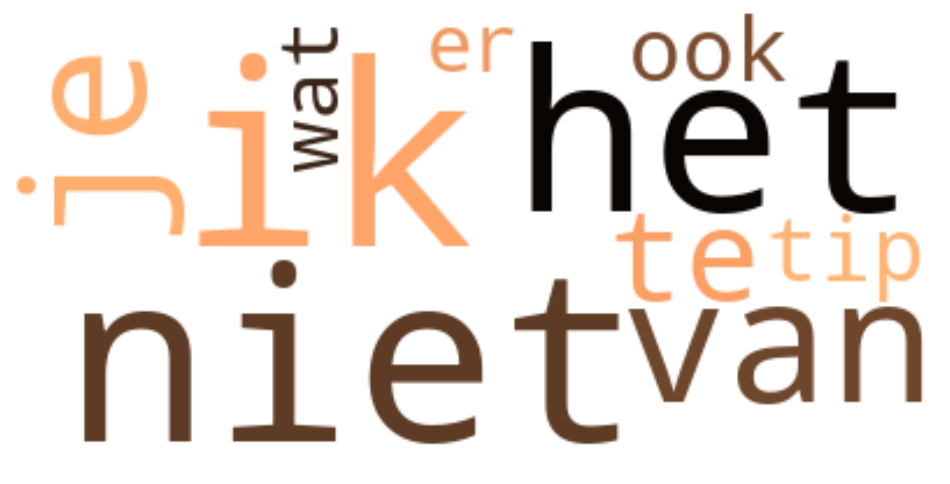

WORDCLOUD for 3.0


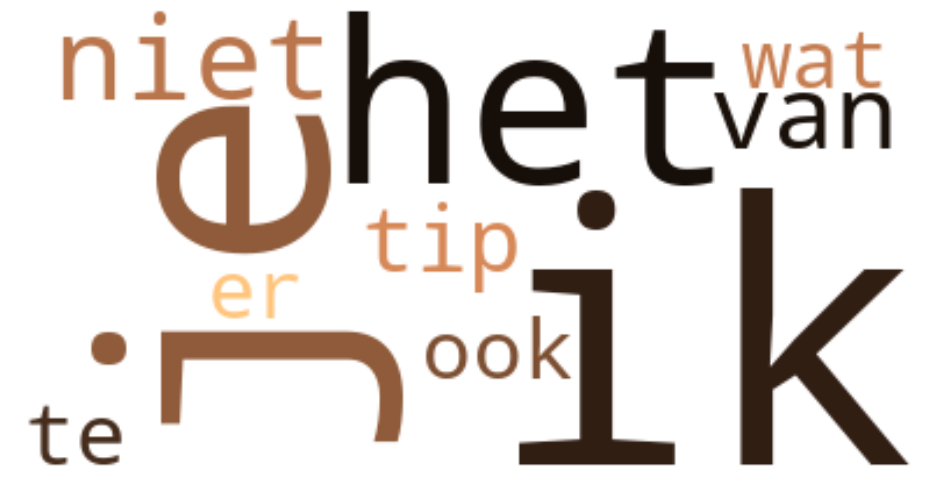

WORDCLOUD for 9.5


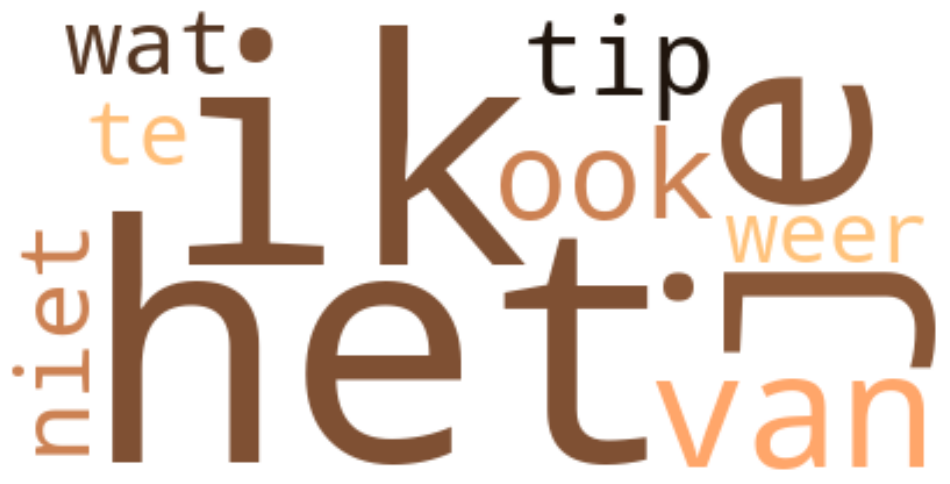

WORDCLOUD for 2.0


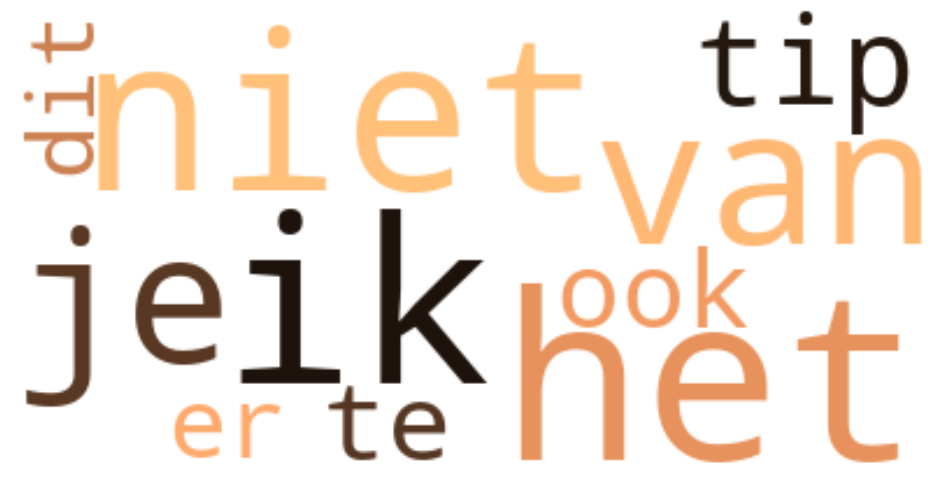

WORDCLOUD for 2.5


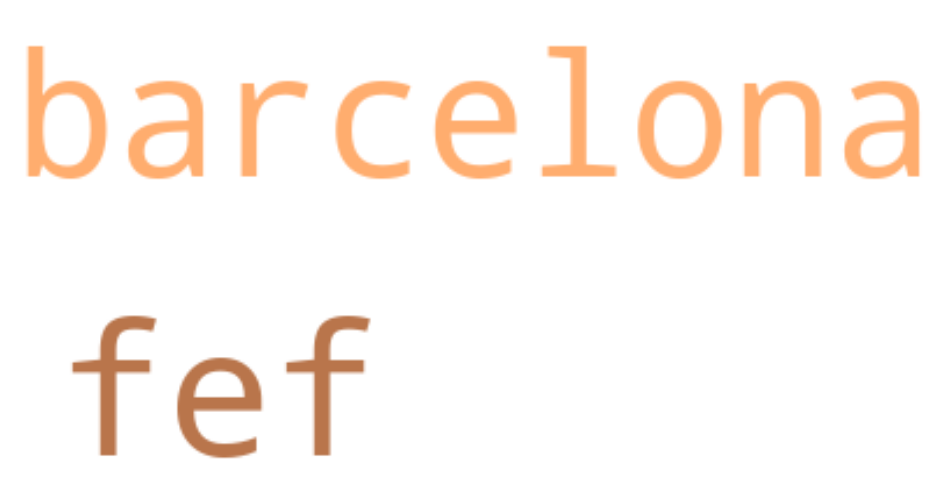

WORDCLOUD for 5.5


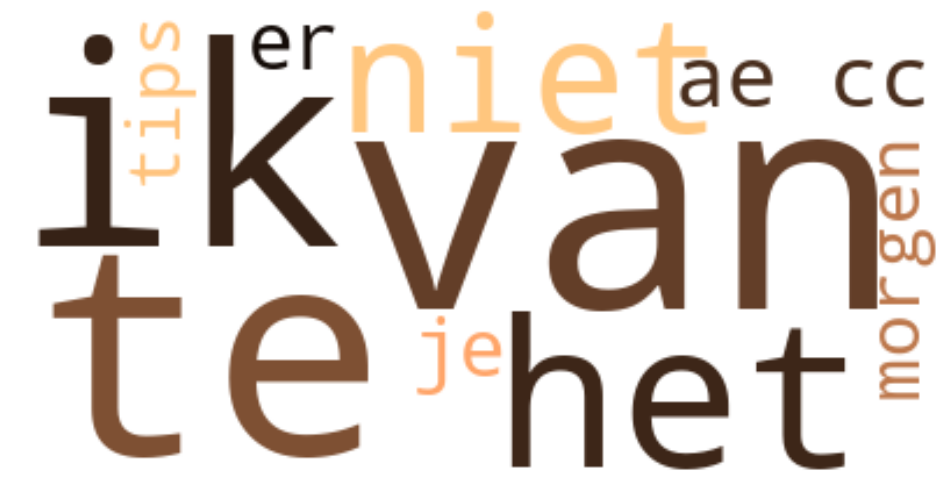

In [114]:
## Top-10 most frequent words amongst the grade categories
tags = df["Grade"].unique()
for tag in tags:
    print("WORDCLOUD for", tag)
    mask_df = df[df["Grade"]==tag]["Gespreksdata"].values
    text = " ".join(mask_df)

    wordcloud = WordCloud(stopwords=stopwords, max_words=10, background_color="white", colormap='copper').generate(text)

    plt.figure(figsize=(12,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print("="*100)

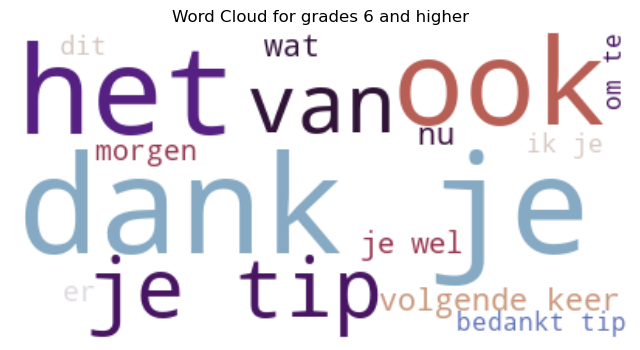

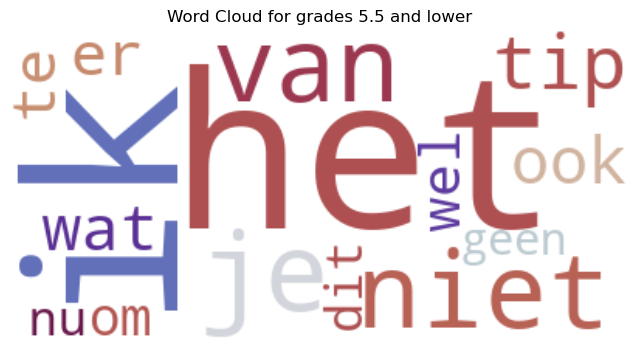

In [117]:
# Grades 6 and higher
grades_higher = df[df["Grade"] >= 6]["Gespreksdata"].values
text_higher = " ".join(grades_higher)

wordcloud_higher = WordCloud(stopwords=stopwords, max_words=15, background_color="white", colormap='twilight_shifted_r').generate(text_higher)

plt.figure(figsize=(8,5))
plt.imshow(wordcloud_higher, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for grades 6 and higher")
plt.show()


# Grades 5.5 and lower
grades_lower = df[df["Grade"] <= 5.5]["Gespreksdata"].values
text_lower = " ".join(grades_lower)

wordcloud_lower = WordCloud(stopwords=stopwords, max_words=15, background_color="white", colormap='twilight_shifted_r').generate(text_lower)

plt.figure(figsize=(8,5))
plt.imshow(wordcloud_lower, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for grades 5.5 and lower")
plt.show()


## 5. Feature Correlations

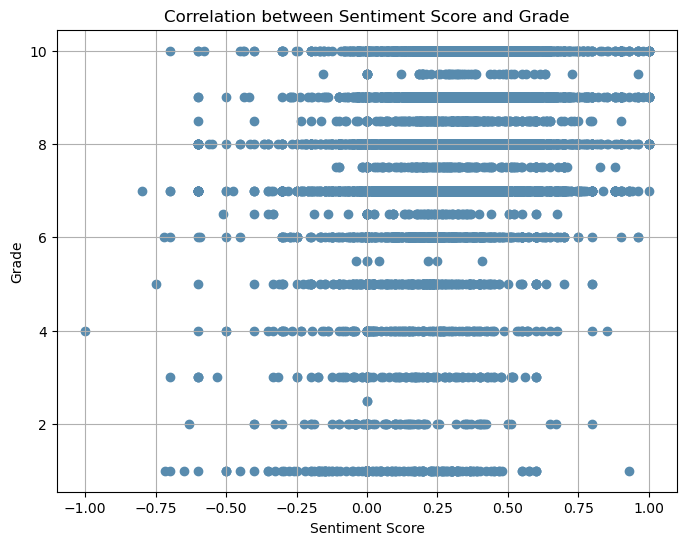

In [140]:
# Scatterplot: Correlation between Sentiment and target feature "Grade"

plt.figure(figsize=(8, 6))
plt.scatter(df['sentiment_score'], df['Grade'], color = '#588BAE')
plt.title('Correlation between Sentiment Score and Grade')
plt.xlabel('Sentiment Score')
plt.ylabel('Grade')
plt.grid(True)
plt.show()

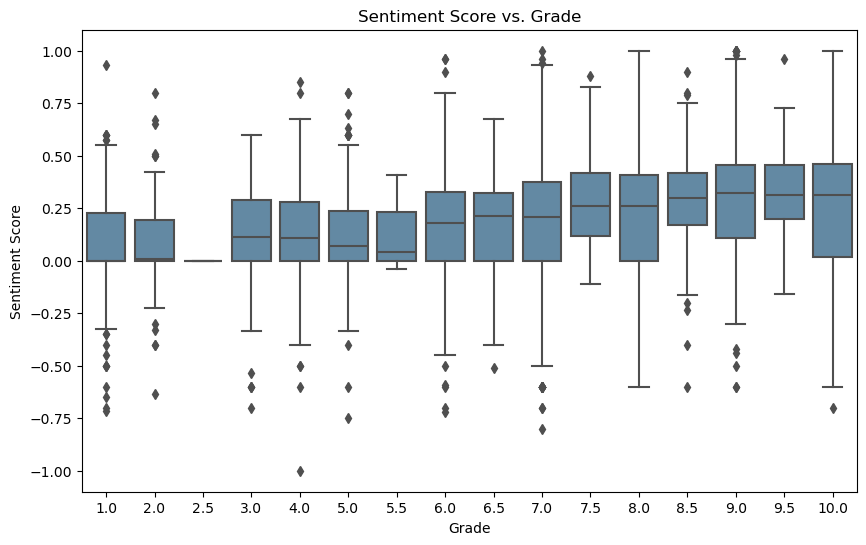

In [143]:
# Boxplot: Correlation between Sentiment and target feature "Grade"

plt.figure(figsize=(10, 6))
sns.boxplot(x="Grade", y='sentiment_score', data=df, color = '#588BAE')
plt.title('Sentiment Score vs. Grade')
plt.xlabel('Grade')
plt.ylabel('Sentiment Score')
plt.show()

In [144]:
a = df['Grade']
b = df['sentiment_score']

In [145]:
stats.spearmanr(a, b)

SignificanceResult(statistic=0.1983587768652265, pvalue=6.110752556306908e-114)

In [150]:
df.head()

,Boekingsnummer,Land,Aankomst,Vertrek,Travel Duration,Received Messages,Gespreksdata,Travel Month,Grade,sentiment_score,subjectivity_score
0,266224,528,2021-03-08,12/03/2021,4,5.0,sophie sophie sophie je weer je hetzelfde bedankt,3,10.0,0.000000,0.300000
3,266990,528,2021-03-01,05/03/2021,4,4.0,sophie sophie ja je volgende keer weer wíj je ...,3,9.0,0.000000,0.200000
6,264877,528,2021-02-21,23/02/2021,2,6.0,sophie sophie van wandelen nijmegen ook zoek r...,2,8.0,0.179167,0.714583
10,270545,528,2021-02-14,16/02/2021,2,6.0,sophie sophie dagen overijssel landgoed holtwe...,2,8.0,0.465000,0.600000
11,267413,528,2021-03-12,15/03/2021,3,8.0,sophie vraagje golf spelen golfbaan kelpenberg...,3,10.0,0.266667,0.483333


In [164]:
# Computing a Correlation Matrix of the numerical features that will be used for prediction

df_filtered = df.drop(columns=['Gespreksdata', 'Aankomst', 'Vertrek', 'Boekingsnummer', 'subjectivity_score', 'Received Messages'])

df_filtered.corr()

,Land,Travel Duration,Travel Month,Grade,sentiment_score
Land,1.000000,0.007771,-0.059270,-0.042372,-0.019359
Travel Duration,0.007771,1.000000,0.093130,-0.085531,0.012333
Travel Month,-0.059270,0.093130,1.000000,0.075546,0.014915
Grade,-0.042372,-0.085531,0.075546,1.000000,0.214466
sentiment_score,-0.019359,0.012333,0.014915,0.214466,1.000000


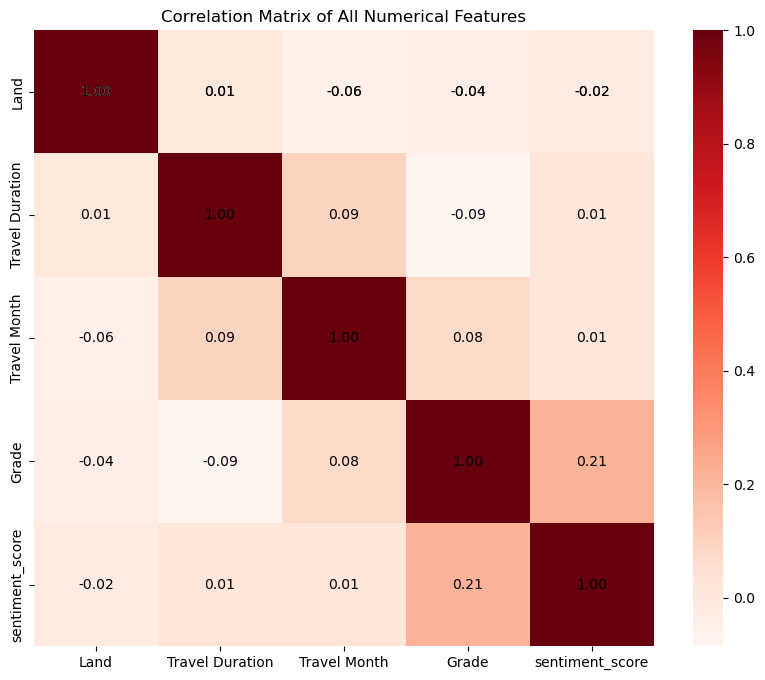

In [163]:
# Visualise Correlation Matrix in a Heat Map

correlation_matrix = df_filtered.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt=".2f")
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j+0.5, i+0.5, '{:.2f}'.format(correlation_matrix.iloc[i, j]), ha='center', va='center')
plt.title('Correlation Matrix of All Numerical Features')
plt.show()